# Why arrow?

This notebook explores the benefits or drawbacks of using the [arrow](https://arrow.apache.org) in-memory data format relative to other formats such as Pandas DataFrames.

In [1]:
# set ipyflow reactive mode
%flow mode reactive

In [2]:
import pathlib

import duckdb
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import polars as pl
import pyarrow as pa
from pyarrow import parquet
from pympler.asizeof import asizeof
from utilities import timer

In [3]:
# target file or table names
image_dir = "images"
parquet_name = "example.parquet"

In [4]:
# remove any existing prior work
pathlib.Path(parquet_name).unlink(missing_ok=True)

In [5]:
# starting rowcount and col count
nrows = 320
ncols = 160

# result list for storing data
results = []

# loop for iterating over increasingly large dataframes
# and gathering data about operations on them
for _ in range(1, 4):
    # increase the size of the dataframe
    nrows *= 2
    ncols *= 2

    # form a dataframe using randomized data
    df = pd.DataFrame(
        np.random.rand(nrows, ncols), columns=[f"col_{num}" for num in range(0, ncols)]
    )
    # write to parquet for tests below
    df.to_parquet(path=parquet_name, compression="snappy")

    # append data to the result list
    results.append(
        {
            # general information about the dataframe
            "dataframe_shape (rows, cols)": str(df.shape),
            # information about pandas
            "pandas_read_time (secs)": timer(pd.read_parquet, path=parquet_name),
            "pandas_size (bytes)": asizeof(pd.read_parquet(path=parquet_name)),
            # information about pyarrow
            "pyarrow_read_time (secs)": timer(parquet.read_table, source=parquet_name),
            "pyarrow_size (bytes)": asizeof(parquet.read_table(source=parquet_name)),
            # information about polars
            "polars_read_time (secs)": timer(
                pl.scan_parquet, source=parquet_name, method_chain="collect"
            ),
            "polars_size (bytes)": pl.scan_parquet(source=parquet_name)
            .collect()
            .estimated_size(),
        }
    )

    # remove any existing files in preparation for next steps
    pathlib.Path(parquet_name).unlink(missing_ok=True)


df_results = pd.DataFrame(results)
df_results

,"dataframe_shape (rows, cols)",pandas_read_time (secs),pandas_size (bytes),pyarrow_read_time (secs),pyarrow_size (bytes),polars_read_time (secs),polars_size (bytes)
0,"(640, 320)",0.037706,3823648,0.015337,1664056,0.004477,1638400
1,"(1280, 640)",0.049357,14198296,0.029631,6656056,0.006508,6553600
2,"(2560, 1280)",0.084412,54610656,0.061539,26624056,0.018988,26214400


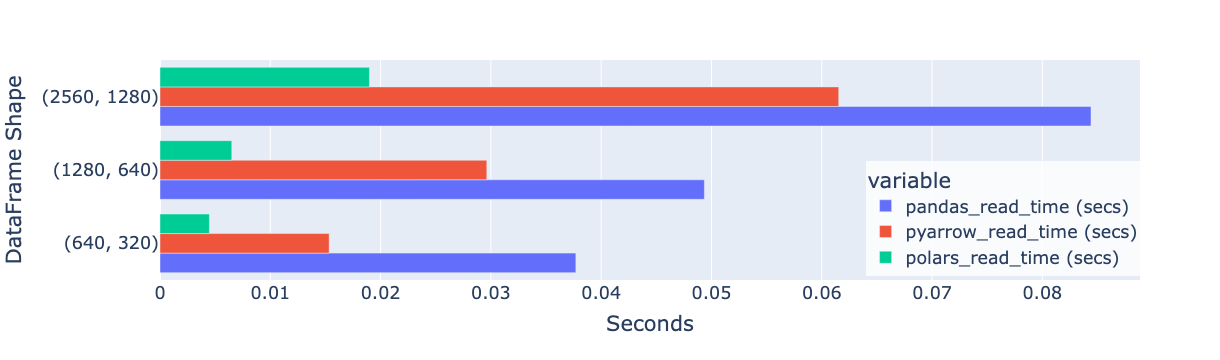

In [20]:
# write times barchart
fig = px.bar(
    df_results,
    x=[
        "pandas_read_time (secs)",
        "pyarrow_read_time (secs)",
        "polars_read_time (secs)",
    ],
    y="dataframe_shape (rows, cols)",
    orientation="h",
    barmode="group",
    labels={"dataframe_shape (rows, cols)": "DataFrame Shape", "value": "Seconds"},
    width=1300,
)
fig.update_layout(
    legend=dict(x=0.72, y=0.02, bgcolor="rgba(255,255,255,0.8)"),
    font=dict(
        size=17.5,  # global font size
    ),
)
fig.show()

pio.write_image(fig, f"{image_dir}/mem-read-times.png")

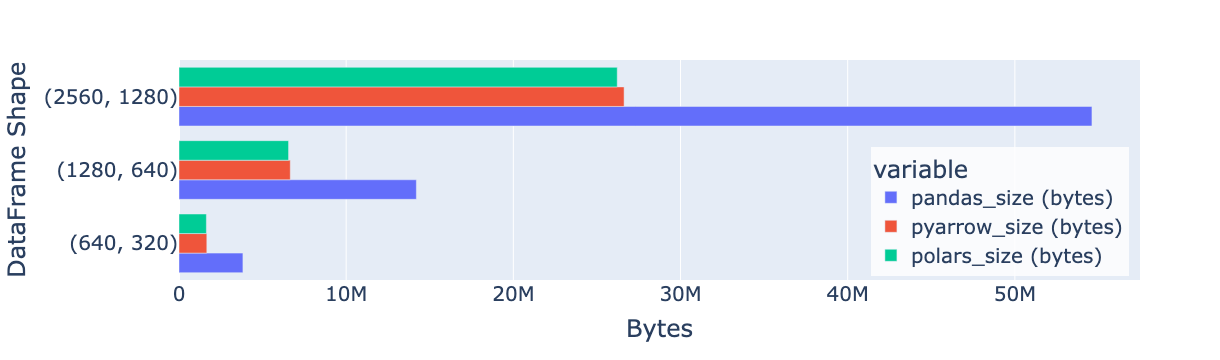

In [22]:
# write times barchart
fig = px.bar(
    df_results,
    x=[
        "pandas_size (bytes)",
        "pyarrow_size (bytes)",
        "polars_size (bytes)",
    ],
    y="dataframe_shape (rows, cols)",
    orientation="h",
    barmode="group",
    labels={"dataframe_shape (rows, cols)": "DataFrame Shape", "value": "Bytes"},
    width=1300,
)
fig.update_layout(
    legend=dict(x=0.72, y=0.02, bgcolor="rgba(255,255,255,0.8)"),
    font=dict(
        size=20,  # global font size
    ),
)
fig.show()

pio.write_image(fig, f"{image_dir}/mem-read-size.png")